In [2]:
#We import our packages
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the first dataset: Life expectancy at birth
We use the first csv dataset to calculate the **life expectancy** at birth in each state of USA in 2015.
We will need to clean our dataset in order to extract, from data related to the different counties, the *average life expectancy* in each state of US.

In [3]:
#We load our dataset
life_expectancy_original=pd.read_csv("Data/U.S._Life_Expectancy_at_Birth_by_State_and_Census_Tract_-_2010-2015.csv")
life_expectancy_original

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error
0,Alabama,Autauga County,201.0,73.1,56.3 - 75.0,2.2348
1,Alabama,Autauga County,202.0,76.9,75.1 - 77.4,3.3453
2,Alabama,Autauga County,204.0,75.4,75.1 - 77.4,1.0216
3,Alabama,Autauga County,205.0,79.4,77.5 - 79.4,1.1768
4,Alabama,Autauga County,206.0,73.1,56.3 - 75.0,1.5519
...,...,...,...,...,...,...
73104,Virginia,NaN,NaN,79.4,77.5 - 79.4,0.0250
73105,Washington,NaN,NaN,80.3,79.5 - 81.5,0.0270
73106,West Virginia,NaN,NaN,75.3,75.1 - 77.4,0.0520
73107,Wisconsin,NaN,NaN,79.6,79.5 - 81.5,0.0290


We can notice how some values are missing. 
We have different situations in different rows:
1. The data for County and Census Tract are present, but not the data about life expectancy.
In this case, the problem could be linked to missing data in collecting them in different Census Tracts. We decide to ignore these data, dropping them so that they will not affect our analysis.
2. The data for County are present, with relative life expectancy, but not the related Census Tract Number.
Why? We hypotise this data could be the average value of life expectancy per county, but our source do not specify it! In the database description it is only mentioned "the life expectancy per Census Tract", not that it contained further analysis! We decide to drop them and do our analysis without them.
3. The data for State are present, with relative life expectancy, but not the related County and Census Tract Number.
Same as before!
4. Wisconsin and Maine have no data! We will need to consider these missing data!

**Attention!:** in doing this, we are probably introducing some errors, and as we will consider some approximations, if the data 2. and 3. were the hypotised ones, they probably would be more accurate! But we don't know it, so we decide to go further with our analysis and the resting data.

In [4]:
life_expectancy_original=life_expectancy_original.dropna()
life_expectancy_original

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error
0,Alabama,Autauga County,201.00,73.1,56.3 - 75.0,2.2348
1,Alabama,Autauga County,202.00,76.9,75.1 - 77.4,3.3453
2,Alabama,Autauga County,204.00,75.4,75.1 - 77.4,1.0216
3,Alabama,Autauga County,205.00,79.4,77.5 - 79.4,1.1768
4,Alabama,Autauga County,206.00,73.1,56.3 - 75.0,1.5519
...,...,...,...,...,...,...
67462,Wyoming,Washakie County,2.00,80.1,79.5 - 81.5,2.6916
67463,Wyoming,Washakie County,3.01,79.9,79.5 - 81.5,2.8024
67464,Wyoming,Washakie County,3.02,81.8,81.6 - 97.5,2.0776
67465,Wyoming,Weston County,9511.00,79.0,77.5 - 79.4,1.0697


In [5]:
life_expectancy_columns=life_expectancy_original[['State','County','Census Tract Number','Life Expectancy']]
life_expectancy_columns
#We drop the column about the Life Expectancy Range, as we need a precise calculation of our value 
#and not a range, while we effectuate our analysis about the average life expectancy, and do not care
#about the standard error for each Census Tract

,State,County,Census Tract Number,Life Expectancy
0,Alabama,Autauga County,201.00,73.1
1,Alabama,Autauga County,202.00,76.9
2,Alabama,Autauga County,204.00,75.4
3,Alabama,Autauga County,205.00,79.4
4,Alabama,Autauga County,206.00,73.1
...,...,...,...,...
67462,Wyoming,Washakie County,2.00,80.1
67463,Wyoming,Washakie County,3.01,79.9
67464,Wyoming,Washakie County,3.02,81.8
67465,Wyoming,Weston County,9511.00,79.0


## What is a census tract? (From https://en.wikipedia.org/wiki/Census_tract)
A *census tract*, census area, census district or meshblock is a geographic region defined for the purpose of taking a census. Sometimes these coincide with the limits of cities, towns or other administrative areas and several tracts commonly exist within a county. In unincorporated areas of the United States these are often arbitrary, except for coinciding with political lines.
Census tracts represent the **smallest territorial entity for which population data are available in many countries**. In the United States, census tracts are subdivided into block groups and census blocks. In Canada they are divided into dissemination areas. In the U.S., census tracts are "designed to be relatively homogeneous units with respect to population characteristics, economic status, and living conditions" and "average about 4,000 inhabitants".

## How will it be useful for our calculations?
From our dataset, we can see how different counties have different numbers of census tracts.
To calculate our value of life expectancy for each state, we should know how many people are in each census tract, and calculate the weighted average.
But we do not have this information!

*Census tracts generally contain between 1,000 and 8,000 people with an optimum size of 4,000 people. Census tract boundaries are delineated with the intention of being stable over many decades, so they generally follow relatively permanent visible features.* (From https://pitt.libguides.com/uscensus/understandinggeography)
They are made in order to be **more or less all of the same dimension!**
Calculating the average of all the census tract values should not affect that much our analysis!

In [6]:
#We group our data per state
life_expectancy_grouped=life_expectancy_columns.groupby(life_expectancy_columns.State)
life_expectancy_grouped.head()

,State,County,Census Tract Number,Life Expectancy
0,Alabama,Autauga County,201.0,73.1
1,Alabama,Autauga County,202.0,76.9
2,Alabama,Autauga County,204.0,75.4
3,Alabama,Autauga County,205.0,79.4
4,Alabama,Autauga County,206.0,73.1
...,...,...,...,...
67349,Wyoming,Albany County,9627.0,80.4
67350,Wyoming,Albany County,9628.0,82.0
67351,Wyoming,Albany County,9629.0,81.1
67352,Wyoming,Albany County,9630.0,76.8


In [7]:
#We calculate the mean 
life_expectancy=life_expectancy_grouped.mean()[['Life Expectancy']]
life_expectancy.columns=['Life_Expectancy']
life_expectancy

,Life_Expectancy
State,
Alabama,74.813987
Alaska,78.915541
Arizona,78.364742
Arkansas,75.626900
California,80.231014
Colorado,79.465953
Connecticut,80.101405
Delaware,77.793939
District of Columbia,76.407879


We manage to find data about Maine and Winconsin on this site: https://www.worldlifeexpectancy.com/usa/maine-life-expectancy
The data are related to 2014, but they can be compared to the the data about the following year, and are of course still better than a missing data!
We decide to append them to our Dataframe!

In [8]:
df1=pd.DataFrame([{'State': 'Maine', 'Life_Expectancy': 79.19},
                  {'State': 'Wisconsin', 'Life_Expectancy': 79.98}])
df1.set_index('State',inplace=True)
df1

,Life_Expectancy
State,
Maine,79.19
Wisconsin,79.98


In [9]:
life_expectancy=pd.concat([life_expectancy, df1], axis=0)
life_expectancy

,Life_Expectancy
State,
Alabama,74.813987
Alaska,78.915541
Arizona,78.364742
Arkansas,75.626900
California,80.231014
Colorado,79.465953
Connecticut,80.101405
Delaware,77.793939
District of Columbia,76.407879


In [10]:
#We reorder the dataframe sorting on the state
life_expectancy=life_expectancy.sort_values('State')
life_expectancy

,Life_Expectancy
State,
Alabama,74.813987
Alaska,78.915541
Arizona,78.364742
Arkansas,75.626900
California,80.231014
Colorado,79.465953
Connecticut,80.101405
Delaware,77.793939
District of Columbia,76.407879


We finally have the first information we need: the **life expectancy in every state of USA.**
We plot our obtained data in order to identify outliers and evaluate wheter we need to do something else.

(array([2., 4., 2., 1., 5., 2., 2., 4., 5., 7., 4., 5., 5., 1., 2.]),
 array([74.81398728, 75.24738104, 75.6807748 , 76.11416855, 76.54756231,
        76.98095606, 77.41434982, 77.84774357, 78.28113733, 78.71453108,
        79.14792484, 79.58131859, 80.01471235, 80.44810611, 80.88149986,
        81.31489362]),
 <a list of 15 Patch objects>)

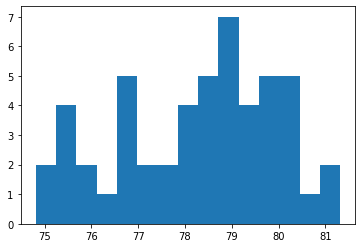

In [11]:
plt.hist(life_expectancy.Life_Expectancy, bins=15)

We can see how data seem to be quite homogeneous! Our work seems to be fine!

In [12]:
#We sort our data to see which state is the "Life Expectancy Champion!"
life_expectancy_sorted=life_expectancy.sort_values('Life_Expectancy', ascending=False)
life_expectancy_sorted

,Life_Expectancy
State,
Hawaii,81.314894
Vermont,81.022286
Minnesota,80.468912
Massachusetts,80.340246
New York,80.326875
California,80.231014
Wyoming,80.161017
Connecticut,80.101405
Wisconsin,79.980000


**Hawaii  is the life expectancy champion!** We will expect in our final analysis that this state (with other like Vermont or Minnesota) will have high rates when giving importance to the quality of life, while states like Louisiana, Minnesota or Alabama will be less rated.

## Loading the second dataset: Disposable personal income
Our second csv dataset regards the disposable personal income! Let's import it, in order to see how it is structured!

In [13]:
#We load our dataset
income_original=pd.read_csv("Data/personal_income_and_population.csv", sep=',', skiprows=4)
income_original
#We skip the first 4 rows, as they just are a description of what the dataset is about

,GeoFips,GeoName,LineCode,Description,2018
0,00000,United States*,51.0,Disposable personal income (millions of dollars),15737171.0
1,00000,United States*,52.0,Population (persons) 1/,327167434.0
2,00000,United States*,53.0,Per capita disposable personal income (dollars...,48101.0
3,01000,Alabama,51.0,Disposable personal income (millions of dollars),186791.1
4,01000,Alabama,52.0,Population (persons) 1/,4887871.0
...,...,...,...,...,...
181,1/ Census Bureau midyear population estimate. ...,NaN,NaN,NaN,NaN
182,2/ Per capita disposable personal income is to...,NaN,NaN,NaN,NaN
183,* Alaska and Hawaii are included in the U.S. a...,NaN,NaN,NaN,NaN
184,Note-- All dollar estimates are in millions of...,NaN,NaN,NaN,NaN


In [14]:
#Also the last 6 rows are just a legend of the dataset! We can drop them!
income_original=income_original.drop([180, 181, 182, 183, 184, 185])
income_original

,GeoFips,GeoName,LineCode,Description,2018
0,00000,United States*,51.0,Disposable personal income (millions of dollars),15737171.0
1,00000,United States*,52.0,Population (persons) 1/,327167434.0
2,00000,United States*,53.0,Per capita disposable personal income (dollars...,48101.0
3,01000,Alabama,51.0,Disposable personal income (millions of dollars),186791.1
4,01000,Alabama,52.0,Population (persons) 1/,4887871.0
...,...,...,...,...,...
175,97000,Rocky Mountain,52.0,Population (persons) 1/,12250919.0
176,97000,Rocky Mountain,53.0,Per capita disposable personal income (dollars...,46495.0
177,98000,Far West*,51.0,Disposable personal income (millions of dollars),3015721.6
178,98000,Far West*,52.0,Population (persons) 1/,56475670.0


Our dataset is a **long dataframe** where each geographic region has 3 values:
1. Disposable personal income (millions of dollars) --> LineCode==51.0
2. Population --> LineCode==52.0
3. Per capita personal income (dollars) --> LineCode==53.0

We are interested in the *per capita personal income*, that is to say an individual's total earnings from wages, investment enterprises, and other ventures. We could describe it as the money every person disposes for its necessities.
However, the population of each state could probably be really useful for our analysis in the further stages of it.
We want to build a **large dataframe** where every geographic region involved has 2 parameters: Per capita personal income and population.

In [15]:
#We create a DataFrame for the personal income
personal_income=income_original[[x==53.0 for x in income_original.LineCode]]
personal_income.head()
#We keep of this DataFrame just the informations we need, rename the columns and set the state as the index
personal_income=personal_income[['GeoName','2018']]
personal_income.columns=['State','Per_capita_income']
personal_income.set_index('State', inplace=True)
personal_income.head()

,Per_capita_income
State,
United States*,48101.0
Alabama,38215.0
Alaska*,54430.0
Arizona,39955.0
Arkansas,39171.0


In [16]:
#We do the same for the population!
population=income_original[[x==52.0 for x in income_original.LineCode]]
population.head()
population=population[['GeoName','2018']]
population.columns=['State','Population']
population.set_index('State', inplace=True)
population.head()

,Population
State,
United States*,327167434.0
Alabama,4887871.0
Alaska*,737438.0
Arizona,7171646.0
Arkansas,3013825.0


## We have now 3 DataFrame
1. **life_expectancy**
2. **personal_income**
3. **population**

All the 3 have "State" as index!
But we can notice that in the last 2 we have more geographical areas than the needed States!
Moreover, some of these geographical areas have an asterisk at the end of the name!
1. We need to solve the second problem
2. When solved, we can just perform an inner join between the first dataset and the following 2 in order to have just the States we need! In fact, life_expectancy just have our States!

In [20]:
#We start merging population and personal_income that have the same index
pop_inc=pd.merge(population, personal_income, left_index=True, right_index=True)
pop_inc.head()

,Population,Per_capita_income
State,,
United States*,327167434.0,48101.0
Alabama,4887871.0,38215.0
Alaska*,737438.0,54430.0
Arizona,7171646.0,39955.0
Arkansas,3013825.0,39171.0


In [21]:
pop_inc=pop_inc.reset_index()
for x in pop_inc.State:
    if x.endswith('*'):
        x=x[:-1]
pop_inc.head()

,State,Population,Per_capita_income
0,United States*,327167434.0,48101.0
1,Alabama,4887871.0,38215.0
2,Alaska*,737438.0,54430.0
3,Arizona,7171646.0,39955.0
4,Arkansas,3013825.0,39171.0
